In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset

from torchvision.transforms import v2
import torchvision.utils as vutils
from torchvision import datasets

In [2]:
batch_size = 128

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5)] # This we need when fitting a NN with nn.Linear(), but should not do this when using nn.Conv2d
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Getting a subset of the data for speed purposes
num_samples = 60000
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=False)

First we make the discriminator. This is the network that should be able to distinguish the items from the original dataset from fake generated data. It should resemble a function $D:x\to(0,1)$ In this case, $x$ are vectors that describe a number in the MNIST dataset.

In [3]:
noise_dimension = 64

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class Generator(nn.Module):
    """"""
    def __init__(self, z_dimension):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 128), # or 128?
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 784),
            nn.LeakyReLU(0.1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.network(z).view(-1, 1, 28, 28)

In [4]:
lr = 3e-4
epochs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lossfunction = nn.BCELoss()

generate = Generator(noise_dimension).to(device)
discriminate = Discriminator().to(device)

# generate = GeneratorConv(noise_dimension).to(device)
# discriminate = DiscriminatorConv().to(device)

optimizer_gen = optim.Adam(generate.parameters(), lr=lr)
optimizer_disc = optim.Adam(discriminate.parameters(), lr=lr)

Here we code the training loop.

$$E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1- D(G(z)))$$

The left expectation is the real part, the right expectation is called the fake part

BCELoss $(x,y) = \frac{1}{n}\sum_{i=1}^n[y_i\log(x_i) +(1-y_i)\log(1-x_i)]$

In [5]:
K = 2
epochs = 1

for epoch in range(epochs):
    # Total number of loops

    # Initialize cumulative loss values for the epoch
    total_batches = len(train_loader)
    running_loss_disc = 0.0
    running_loss_gen = 0.0

    for k in range(K):
        # Update the generating distribution K times before a single update of the discriminator

        for i, batch in enumerate(train_loader):
            # Apply minibatch gradient descent
            # Generate fake images for updating the generator
            optimizer_disc.zero_grad()

            batch_size = batch[0].size(0)
            real_images = batch[0].to(device) ###########################

            noise = torch.randn(batch_size, noise_dimension, device=device)           #             z
            fake_images = generate(noise)                                             #           G(z)

            fake_images_disc = discriminate(fake_images.detach())                     #         D(G(z))
            real_images_disc = discriminate(real_images)

            # Make some helper values that help selecting the correct part of BCELoss
            y_ones = torch.ones(batch_size, 1, device=device)
            y_zeros = torch.zeros(batch_size, 1, device=device)
            
            # Computing the loss function (As in Algorithm 1 in Goodfellow)
            loss_data = lossfunction(real_images_disc, y_zeros)                         # E log D(x)
            loss_generated = lossfunction(fake_images_disc, y_ones)                   # E log(1-D(G(z))
            loss_discriminator = loss_data + loss_generated

            # Update the discriminator using 'loss'.
            loss_discriminator.backward()
            optimizer_disc.step()

            running_loss_disc += loss_discriminator.item()
            
    # Update the generator using newly generated 
    for i, batch in enumerate(train_loader):
        
        optimizer_gen.zero_grad()

        noise = torch.randn(batch_size, noise_dimension, device=device)
        fake_images = generate(noise)
        fake_images_disc = discriminate(fake_images)

        # Compute loss of the discriminator
        loss_generator = lossfunction(fake_images_disc, y_zeros)
        loss_generator.backward()
        optimizer_gen.step()

        running_loss_gen += loss_generator.item()

    avg_loss_disc = running_loss_disc / (K * total_batches)
    avg_loss_gen = running_loss_gen / total_batches

    # Display the epoch progress
    progress = (epoch + 1) / epochs * 100
    print(f"Epoch [{epoch + 1}/{epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f}")
    


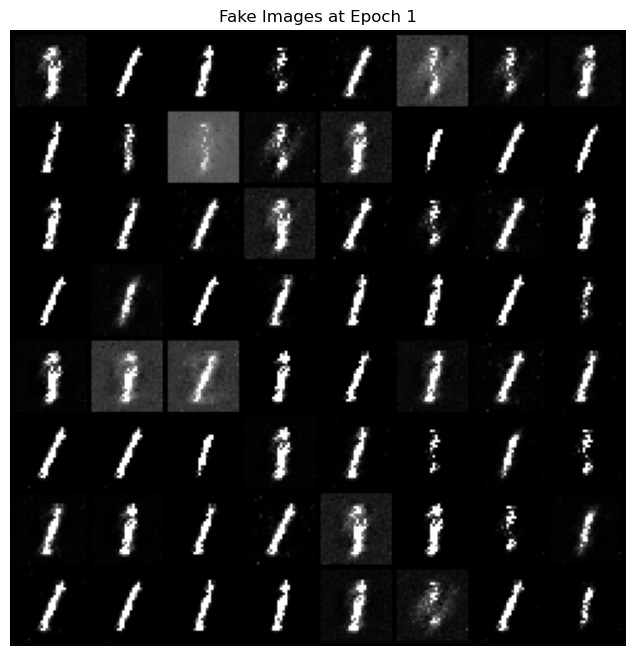

In [28]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Fake Images at Epoch {epoch + 1}")
plt.imshow(vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))
plt.show()

Above, both the discriminator and the generator are fully connected NN's. For image data, it may be more interesting to make the discriminator into a convolutional NN, and the generator a deconvolutional neural net.

$$D:R^{784}\to[0,1]$$
$$G:R^{32}\to X \subseteq R^{784}$$

Where $X$ is the image-space

In [29]:
# Discriminator class
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # Zoek uit wat deze argumenten inhouden
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # outputs 32 14 14

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # Zoek uit wat deze argumenten inhouden
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # outputs 64 7 7

            nn.Flatten(),

            nn.Linear(64*7*7, 64),
            nn.ReLU(),
            
            nn.Linear(64, 16),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class GeneratorConv(nn.Module):
    """"""
    def __init__(self, z_dimension):
        super(GeneratorConv, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 32), # or 128?
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 784),
            nn.LeakyReLU(0.1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.network(z).view(-1, 1, 28, 28)